## mAP — mean Average Precision

AP (Average Precision — средняя точность) — это площадь под сглаженной PR-кривой.

m (mean) —  усредненная для разных порогов IoU.

Разберемся, что это значит.

### Precision & recall

**Precision** измеряет, насколько точны предсказания сети (т.е. процент правильных предсказаний)

**Recall** измеряет, насколько хорошо сеть находит все положительные срабатывания (*positives*). Например, мы можем найти 80% возможных положительных срабатываний в наших $K$ лучших предсказаниях.

Вот их математические определения:

$\displaystyle\mathrm{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$

$\displaystyle\mathrm{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}$

где $\text{TP}$ — True Positive, $\text{TN}$ — True Negative, $\text{FP}$ — False Positive, $\text{FN}$ — False Negative.



Например, мы пытаемся детектировать яблоки на фотографиях. Предположим, мы обработали 20 фотографий (на 10 фотографиях по одному яблоку и на 10 фотографиях яблок нет) и обнаружили, что:

* в 7 случаях наша нейросеть обнаружила яблоко там, где оно было на самом деле (True Positive);
* в 3 случаях не обнаружила яблоко там, где оно было (False Negative);
* в 4 случаях обнаружила яблоко там, где его не было (False Positive);
* в 6 случаях правильно определила, что на фотографии яблок нет (True Negative).



Посчитаем precision и recall:

In [ ]:
def precision(TP, FP):
    return TP / (TP + FP)


def recall(TP, FN):
    return TP / (TP + FN)


pres = precision(TP=7, FP=4)
rec = recall(TP=7, FN=3)

print("Precision = %.2f" % pres)
print("Recall = %.2f" % rec)

Precision = 0.64
Recall = 0.70


### PR-Curve

Зная Precision и Recall для разных порогов, можно построить так называемую [PR-кривую ✏️[blog]](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

[[git] 🐾 Как построить PR-curve](https://github.com/Gan4x4/ml_snippets/blob/main/Training/PR_curve.ipynb)

При помощи таких кривых часто оценивают модели в задачах классификации, когда данные не сбалансированы.

Для получения значений Precision и Recall требуются:

*  Ground True метки;
*  уверенность модели в каждом предсказании.

In [ ]:
import numpy as np

y_true = np.array([1, 1, 0])  # Labels
y_pred = np.array([0.8, 0.1, 0.2])  # Predictions

Этого достаточно для того, чтобы построить PR-кривую для предсказаний одного класса.

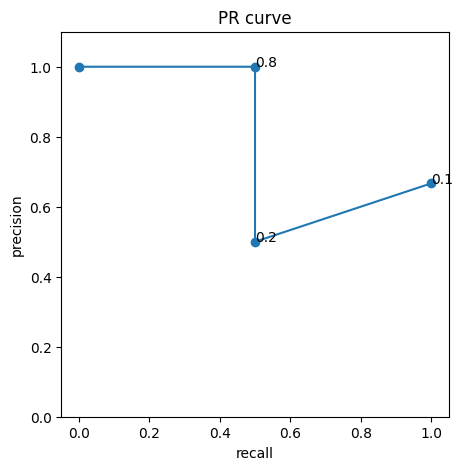

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


def pr_curve(y_true, y_pred):
    plt.figure(figsize=(5, 5))
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, marker="o")
    for i, t in enumerate(thresholds):
        plt.annotate(str(t), (recall[i], precision[i]))
    plt.ylim([0, 1.1])
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title("PR curve")
    plt.show()


pr_curve(y_true, y_pred)

### IoU вместо метки класса

При детектировании у нас  **нет меток класса** для предсказанных bounding
boxes.

Есть предсказанные детектором bboxes в виде:

In [ ]:
import pandas as pd

detections = np.array(
    [
        [290, 50, 170, 160, 0.7, 53],  # x, y, w, h, confidence, class_num
        [10, 200, 190, 180, 0.8, 53],
        [310, 250, 120, 130, 0.75, 53],
    ]
)
pd.DataFrame(
    data=detections, columns=["x", "y", "width", "height", "confidence", "class_num"]
)

,x,y,width,height,confidence,class_num
0,290.0,50.0,170.0,160.0,0.70,53.0
1,10.0,200.0,190.0,180.0,0.80,53.0
2,310.0,250.0,120.0,130.0,0.75,53.0



И есть Ground True bounding box из разметки:

In [ ]:
!wget -qN "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
# !wget -qN "https://ml.gan4x4.ru/msu/datasets/annotations_trainval2017.zip"
!unzip -qn annotations_trainval2017.zip

In [ ]:
from pycocotools.coco import COCO
from IPython.display import clear_output


coco = COCO("annotations/instances_val2017.json")
clear_output()

apples_img_id = 60855  # if of some image with apples
apple_cat_id = 53  # apple

ann_id = coco.getAnnIds(imgIds=[apples_img_id])
anns = coco.loadAnns(ann_id)

gt_bbox = []
for ann in anns:
    if ann["category_id"] == apple_cat_id:
        gt_bbox.append(ann["bbox"] + [ann["category_id"]])


pd.DataFrame(data=gt_bbox, columns=["x", "y", "width", "height", "class_num"])

,x,y,width,height,class_num
0,269.44,61.96,154.91,161.48,53
1,24.26,208.04,177.04,176.13,53


Идея состоит в том, чтобы посчитать максимальный IoU между этими bounding boxes и использовать его вместо метки класса (True/False).



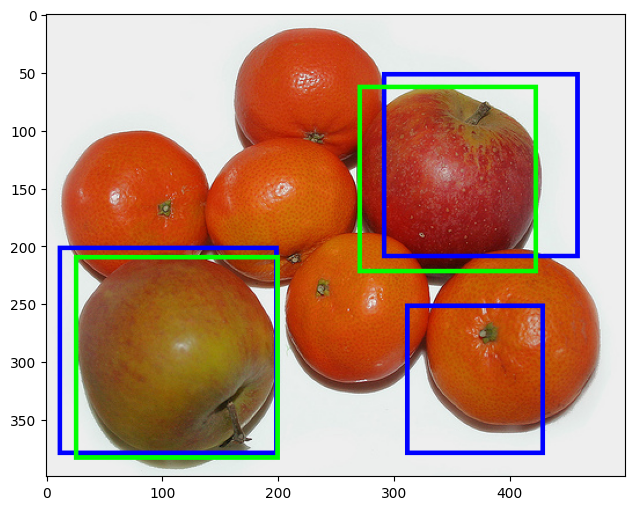

In [ ]:
import torch
import skimage
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes


def draw_bbox(img, bb_xywh, color):
    t_img = torch.tensor(img).permute(2, 0, 1)  # to tensor CHW
    xywh = torch.tensor(bb_xywh)[:, :4]  # take only coords
    bb = box_convert(xywh, "xywh", "xyxy")  # convert from COCO format
    img_with_bb = draw_bounding_boxes(t_img, bb, colors=color, width=4)
    return img_with_bb.permute(1, 2, 0).numpy()  # back to numpy HWC


img_info = coco.loadImgs(apples_img_id)

img = skimage.io.imread(img_info[0]["coco_url"])
img = draw_bbox(img, detections, "blue")
img = draw_bbox(img, gt_bbox, "lime")
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.show()

Чтобы получить максимальное значение $\text{IoU}$  для каждого предсказанного bbox,  воспользуемся функцией `torchvision.ops.box_iou` 🛠️[[doc]](https://pytorch.org/vision/main/generated/torchvision.ops.box_iou.html).

Перед этим преобразуем формат координат к `(x1, y1, x2, y2)`:

In [ ]:
gt = box_convert(torch.tensor(gt_bbox)[:, :4], "xywh", "xyxy")
pred = box_convert(torch.tensor(detections)[:, :4], "xywh", "xyxy")

И получим IoU для всех возможных пар bbox:


In [ ]:
from torchvision.ops import box_iou

pairwise_iou = box_iou(gt, pred)
print(pairwise_iou)

tensor([[0.6153, 0.0000, 0.0000],
        [0.0000, 0.8595, 0.0000]], dtype=torch.float64)


Нас интересует только максимальный:

In [ ]:
iou, _ = pairwise_iou.max(dim=0)
print(iou)

tensor([0.6153, 0.8595, 0.0000], dtype=torch.float64)


Запишем эти значения в таблицу.


In [ ]:
predictions = torch.tensor(detections)[:, 4]
predictions = torch.vstack((predictions, iou)).T

pd.DataFrame(data=predictions, columns=["confidence", "iou"])

,confidence,iou
0,0.70,0.615274
1,0.80,0.859463
2,0.75,0.000000


Теперь будем использовать IoU как GT метку класса: если он больше некоторого порога, то предсказание верное.

В нашем случае будем считать, что если $\text{IoU}≥0.5$, то предсказание правильное.

In [ ]:
gt = iou > 0.5

predictions = torch.vstack((predictions[:, 0], gt)).T
detection_results = pd.DataFrame(data=predictions, columns=["confidence", "gt"])
detection_results.head()

,confidence,gt
0,0.70,1.0
1,0.80,1.0
2,0.75,0.0


Теперь у нас есть все необходимое для того, чтобы построить PR-кривую:

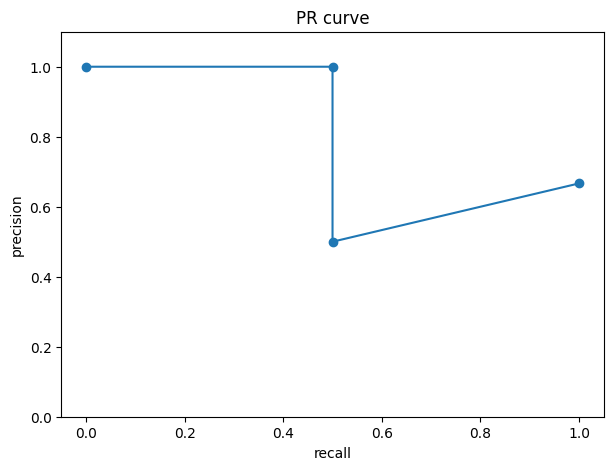

In [ ]:
plt.figure(figsize=(7, 5))
precision, recall, thresholds = precision_recall_curve(gt, predictions[:, 0])
plt.plot(recall, precision, marker="o")
plt.ylim([0, 1.1])
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("PR curve")
plt.show()

### Average Precision

AP — это площадь под PR-кривой.

$\large \displaystyle AP = \int_0^1p(r)dr$

Имея значения Precision и Recall, можно посчитать AP:

In [ ]:
from sklearn.metrics import average_precision_score

ap = average_precision_score(gt, predictions[:, 0])
print("AP", ap)

AP 0.8333333333333333


Сравним это значение с площадью под кривой:

In [ ]:
from sklearn import metrics

auc = metrics.auc(recall, precision)
print("AUC", auc)

AUC 0.7916666666666666


Как видим, они не совпали. Дело в том, что при подсчете AP кривую сглаживают:

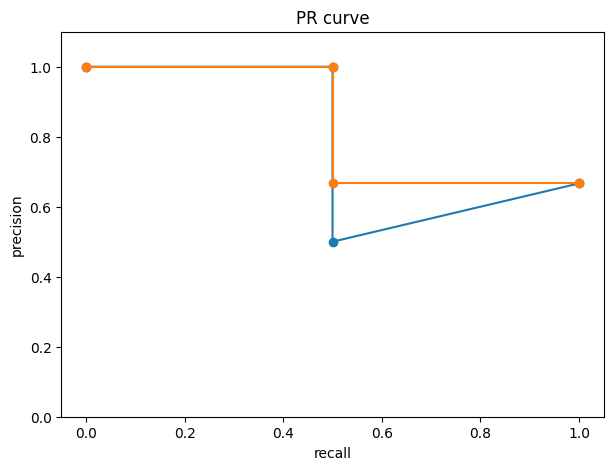

In [ ]:
def smooth_precision(precision):
    smooth_prec = []
    for i in range(1, len(precision) + 1):
        max = precision[:i].max()
        smooth_prec.append(max)
    return smooth_prec


detection_results = detection_results.sort_values("confidence", ascending=False)
precision, recall, thresholds = precision_recall_curve(
    detection_results["gt"], detection_results["confidence"]
)

smoothed_precision = smooth_precision(precision)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, marker="o")
plt.plot(recall, smoothed_precision, marker="o")
plt.ylim([0, 1.1])
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("PR curve")
plt.show()

Так как нас интересует максимальный recall которого можно достичь при определенном precision

In [ ]:
smooth_auc = metrics.auc(recall, smoothed_precision)
print("smooth AUC ", smooth_auc)

smooth AUC  0.8333333333333333


### COCO mAP

Мы посчитали AP для одного класса, но в датасете их много.
Логично усреднить значения AP для разных классов. В некоторых бенчмарках после такого усреднения к названию метрики добавляют приставку m (mean).

*AP is averaged over all categories. Traditionally, this is called “mean average precision” (mAP). We make no distinction between AP and mAP*

### AP для разных порогов.

Мы выбрали для IoU порог 0.5.

Но можно посчитать AP для разных порогов, и затем тоже усреднить. В этом случае в названии метрики указывается минимальный и максимальный пороги.
Например `AP@[.5:.95]` соответствует среднему AP для IoU от 0.5 до 0.95 с шагом 0.05.

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 11.3 MB/s eta 0:00:00


In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

t_gt_bbox = torch.tensor(gt_bbox)
t_detections = torch.tensor(detections)

map_obj = MeanAveragePrecision("xywh", iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75])
results = map_obj(
    preds=[
        {
            "boxes": t_detections[:, :4],  # xywh
            "scores": t_detections[:, 4],  # confidence
            "labels": t_detections[:, 5].int(),  # class num
        }
    ],
    target=[
        {
            "boxes": t_gt_bbox[:, :4],
            "labels": t_gt_bbox[:, 4].int(),
        }  # xywh  # class num
    ],
)

print("mAP@[0.5:0.75] = ", results["map"].item())

mAP@[0.5:0.75] =  0.669966995716095
